In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

train_data = datasets.MNIST(
     root = 'data',
     train = True,
     transform = ToTensor(),
     download=True
 )
test_data = datasets.MNIST(
     root = 'data',
     train = False,
     transform = ToTensor(),
     download=True
 )

loaders = { 

    'train': DataLoader(train_data,
                        batch_size = 100,
                        shuffle = True,
                        num_workers = 1),

    'test': DataLoader(test_data,
                       batch_size = 100,
                       shuffle = True,
                       num_workers = 1),
}

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(loaders["train"].dataset)} ({100.* batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()

    test_loss = 0 
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')

for epoch in range(1, 16):
    train(epoch)
    test()

/var/folders/vg/6pkvjy3x7q79jp13vfc6084h0000gn/T/ipykernel_77472/2310707088.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.300230
Train Epoch: 1 [2000/60000 (3%)]	2.279291
Train Epoch: 1 [4000/60000 (7%)]	2.169095
Train Epoch: 1 [6000/60000 (10%)]	2.049210
Train Epoch: 1 [8000/60000 (13%)]	1.907636
Train Epoch: 1 [10000/60000 (17%)]	1.834978
Train Epoch: 1 [12000/60000 (20%)]	1.831563
Train Epoch: 1 [14000/60000 (23%)]	1.798895
Train Epoch: 1 [16000/60000 (27%)]	1.766413
Train Epoch: 1 [18000/60000 (30%)]	1.719830
Train Epoch: 1 [20000/60000 (33%)]	1.758853
Train Epoch: 1 [22000/60000 (37%)]	1.698595
Train Epoch: 1 [24000/60000 (40%)]	1.668151
Train Epoch: 1 [26000/60000 (43%)]	1.692008
Train Epoch: 1 [28000/60000 (47%)]	1.694395
Train Epoch: 1 [30000/60000 (50%)]	1.660287
Train Epoch: 1 [32000/60000 (53%)]	1.626837
Train Epoch: 1 [34000/60000 (57%)]	1.657595
Train Epoch: 1 [36000/60000 (60%)]	1.622834
Train Epoch: 1 [38000/60000 (63%)]	1.622343
Train Epoch: 1 [40000/60000 (67%)]	1.641235
Train Epoch: 1 [42000/60000 (70%)]	1.625932
Train Epoch: 1 [44000/60000 (73%)]	1.593709

In [3]:
torch.save(model.state_dict(), 'mnist_cnn.pt')

In [4]:
device

device(type='cpu')

/var/folders/vg/6pkvjy3x7q79jp13vfc6084h0000gn/T/ipykernel_77472/2310707088.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 0


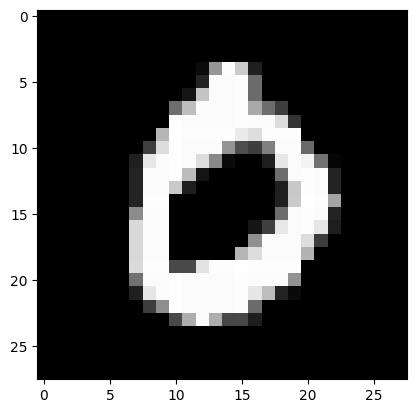

In [7]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[3]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()